In [1]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV

## Nôi dung 
### 1. Xử lý dữ liệu
#### 1.1. Kiểm tra missing
#### 1.2. Kiểm tra phân phối của dữ liệu
#### 1.3. Kiểm tra tính cân bằng dữ liệu
#### 1.4. Outlier
### 2. Phân tích mô tả
#### 2.1 Đánh giá khả năng thanh khoản 
#### 2.2. Đánh giá về hoạt động kinh doanh
#### 2.3. Đánh giá nợ doanh nghiệp 
#### 2.4. Đánh giá khả năng quản lý công nợ, hàng tồn kho 
#### 2.5. Đánh giá tương quan
### 3. Mô hình Logistic
#### 3.1. Phân tích đơn biến
#### 3.2. Phân tích đa biến 
#### 3.3. Xây dựng  và đánh giá mô hình
### 4. Mô hình Random Forest
#### 4.1. Lựa chọn thuộc tính
#### 4.2. Xây dựng  và đánh giá mô hình
### 5. Tổng kết kết quả xây dựng 2 mô hình

In [3]:
#data
df=pd.read_excel('data_bankruptcy.xlsx')

### 1. Xử lý dữ liệu

In [4]:
#1.1. Kiểm tra missing
df.isnull().sum()

NO     0
D      0
YR     0
R1     0
R2     0
R3     0
R4     0
R5     0
R6     0
R7     0
R8     0
R9     0
R10    0
R11    0
R12    0
R13    0
R14    0
R15    0
R16    0
R17    0
R18    0
R19    0
R20    0
R21    0
R22    0
R23    0
R24    0
dtype: int64

Không có dữ liệu thiếu

In [5]:
#1.2. Kiểm tra phân phối dữ liệu
columns_total=[]
for i in range(1,25): 
    var=['R' + str(i)]
    columns_total=columns_total + var
check=pd.DataFrame([])
for i in columns_total:
    shapiro=pd.DataFrame([])
    shapiro['pvalue']=stats.shapiro(df[i])
    shapiro['varr']=i
    check=pd.concat([check,shapiro])
check[check.index==1]

,pvalue,varr
1,2.976040e-20,R1
1,1.518918e-21,R2
1,7.392888e-16,R3
1,1.037463e-16,R4
1,5.837749e-18,R5
1,1.963857e-10,R6
1,5.647205e-08,R7
1,6.826673e-21,R8
1,1.411398e-13,R9
1,2.072293e-23,R10


Kiểm định Shapiro-Wilk với ngưỡng chấp nhận p-value <0.05. Như vậy các dữ liệu không tuân theo phân phối chuẩn

In [6]:
#1.3. Dữ liệu có mất cân bằng không?
df[df['D']==1]['D'].count()/df['D'].count()

0.5

Dữ liệu không mất cân bằng, không cần xử lý về tính cân bằng khi xây dựng model

In [7]:
#1.4 Outlier (tính theo IQR)
df_iqr=df[columns_total].quantile([0.25,0.75],axis=0).T
df_iqr.columns=['q1','q3']
df_iqr['max_iqr']=df_iqr['q3'] + ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_iqr['min_iqr']=df_iqr['q1'] - ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_check_outlier=pd.concat([df[columns_total],df_iqr.T.iloc[2:6,:]])

In [8]:
for i,col  in enumerate(columns_total):
    for j in range(0,132):
        if df_check_outlier.iloc[j,i] > df_check_outlier.iloc[132,i]:
            df_check_outlier.iloc[j,i]=df_check_outlier.iloc[132,i]
        elif df_check_outlier.iloc[j,i] < df_check_outlier.iloc[133,i]:
            df_check_outlier.iloc[j,i]=df_check_outlier.iloc[133,i]
        else:
            df_check_outlier.iloc[j,i]=df_check_outlier.iloc[j,i]
df[columns_total] =df_check_outlier.iloc[:132,:]

### 2. Phân tích mô tả

### 2.1. Đánh giá về thanh khoản

Text(0.5, 1.0, 'Curent asset/Total asset')

<Figure size 1440x1440 with 0 Axes>

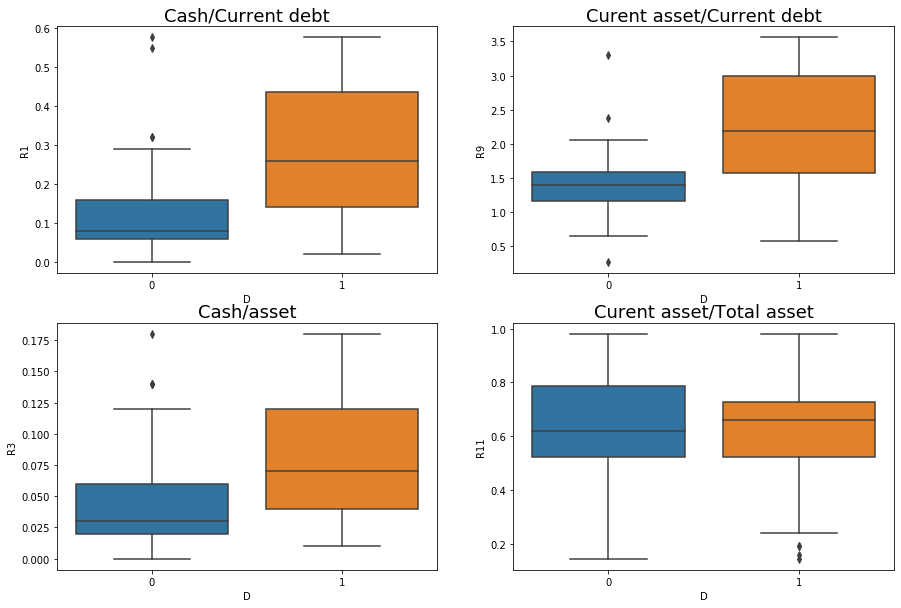

In [9]:
plt.figure(figsize=(20,20))
fig , ax = plt.subplots(2,2,figsize=(15,10))
sns.boxplot(ax=ax[0,0],y = df['R1'], x = df['D']).set_title("Cash/Current debt",size = 18)
sns.boxplot(ax=ax[0,1],y = df['R9'], x = df['D']).set_title("Curent asset/Current debt",size = 18)
sns.boxplot(ax=ax[1,0],y = df['R3'], x = df['D']).set_title("Cash/asset",size = 18)
sns.boxplot(ax=ax[1,1],y = df['R11'], x = df['D']).set_title("Curent asset/Total asset",size = 18)

- Trên đồ thị có thể thấy các doanh nghiệp có sức khỏe tài chính tốt có khả năng thanh khoản cao hơn đáng 
kể so với các doanh nghiệp đã phá sản, cho thấy nguồn tài sản ngắn hạn tốt và khả năng xử lý các khoản 
nợ ngắn hạn tốt hơn.
- Tỷ lệ tài sản ngắn hạn/tài sản dài hạn của 2 loại doanh nghiệp chưa có nhiều khác biệt, như vậy khả năng 
suy giảm tài sản ngắn hạn gây áp lực đến thanh khoản không phải là nguyên nhân dẫn đến phá sản.

### 2.2. Đánh giá về hoạt động kinh doanh

Text(0.5, 1.0, 'Incom(depre)/Sales')

<Figure size 2160x2160 with 0 Axes>

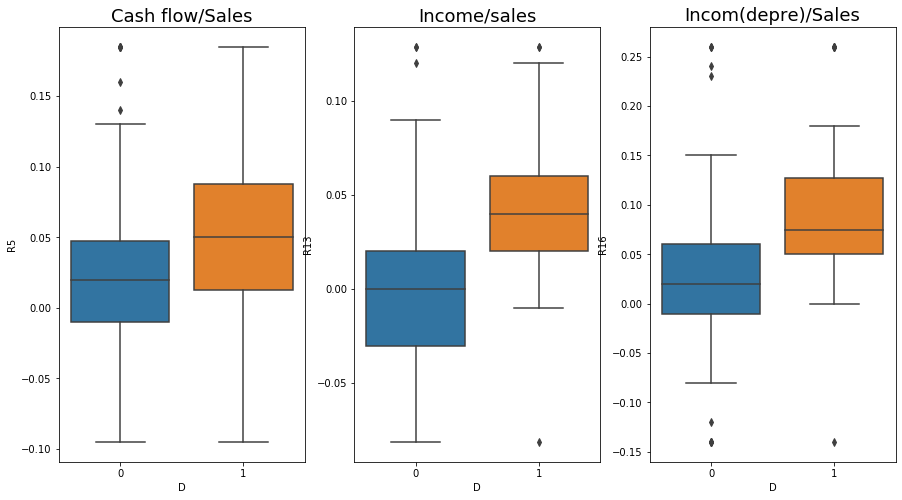

In [10]:
plt.figure(figsize=(30,30))
fig , (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,8))
plt.subplot(ax1)
sns.boxplot(y = df['R5'], x = df['D']).set_title("Cash flow/Sales",size = 18)
plt.subplot(ax2)
sns.boxplot(y = df['R13'], x = df['D']).set_title('Income/sales',size = 18)
plt.subplot(ax3)
sns.boxplot(y = df['R16'], x = df['D']).set_title('Incom(depre)/Sales',size = 18)

- Khá nhiều giá trị Income/Sales <0 tại các doanh nghiệp phá sản, có thể thấy lợi nhuận doanh nghiệp âm. 
Đây là chỉ số cảnh báo vấn đề của doanh nghiệp khi vấn đề đang nằm ở hoạt động kinh doanh. 

### 2.3. Đánh giá nợ 

Text(0.5, 1.0, 'Total assets/Total debt')

<Figure size 2160x2160 with 0 Axes>

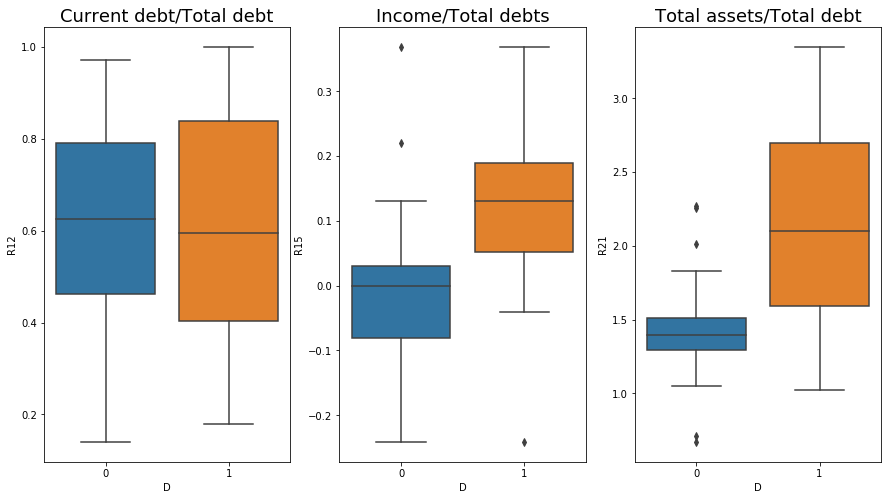

In [11]:
plt.figure(figsize=(30,30))
fig , (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,8))
plt.subplot(ax1)
sns.boxplot(y = df['R12'], x = df['D']).set_title('Current debt/Total debt',size = 18)
plt.subplot(ax2)
sns.boxplot(y = df['R15'], x = df['D']).set_title('Income/Total debts',size = 18)
plt.subplot(ax3)
sns.boxplot(y = df['R21'], x = df['D']).set_title('Total assets/Total debt',size = 18)

- Cơ cấu các khoản nợ không có sự khác biệt giữa các doanh nghiệp tài chính tốt và doanh nghiệp đã 
phá sản, như vậy khả năng các khoản nợ ngắn hạn tăng lên là yếu tố tác động đến phá sản là chưa có 
cơ sở. 
- Các outlier Income/total debt <0 thể hiện các khoản nợ ko có hiệu quả . 
- Chỉ số Total asset/Total debt: các doanh nghiệp tốt có khả năng tự chủ tài chính cao, tài sản được tài 
trợ nhiều bởi vốn chủ sở hữu, tuy nhiên các doanh nghiệp tốt này cũng có thể chưa tận dụng tốt đòn
bẩy tài chính thông qua nguồn vốn huy động.


### 2.4. Đánh giá khả năng quản lý công nợ, quản lý hàng tồn kho

Text(0.5, 1.0, 'Vòng quay khoản phải thu')

<Figure size 2160x2160 with 0 Axes>

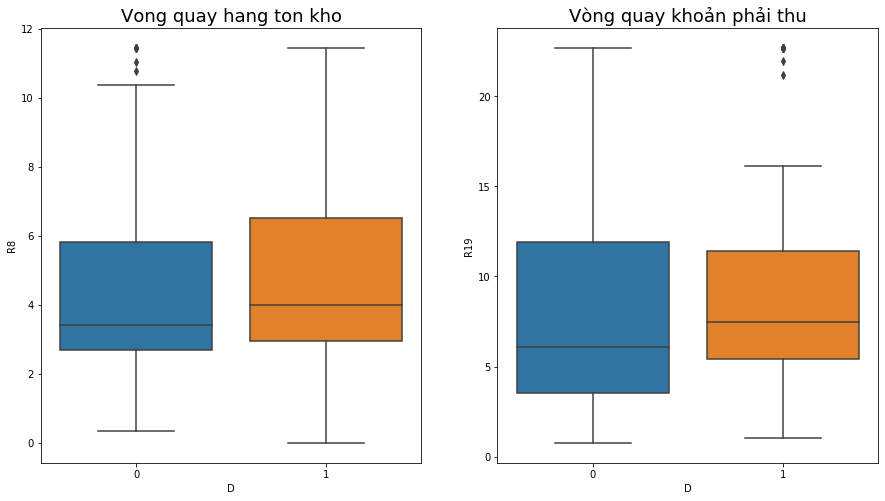

In [12]:
plt.figure(figsize=(30,30))
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
plt.subplot(ax1)
sns.boxplot(y = df['R8'], x = df['D']).set_title('Vong quay hang ton kho',size = 18)
plt.subplot(ax2)
sns.boxplot(y = df['R19'], x = df['D']).set_title('Vòng quay khoản phải thu',size = 18)

- Có thể thấy hàng tồn kho và công nợ không có sự khác biệt nhiều giữa hai nhóm doanh nghiệp đã phá sản 
và doanh nghiệp đang hoạt động => chỉ số này không có (nhiều) tác động đến khả năng phá sản của 
doanh nghiệp


### 2.5. Đánh giá tương quan 

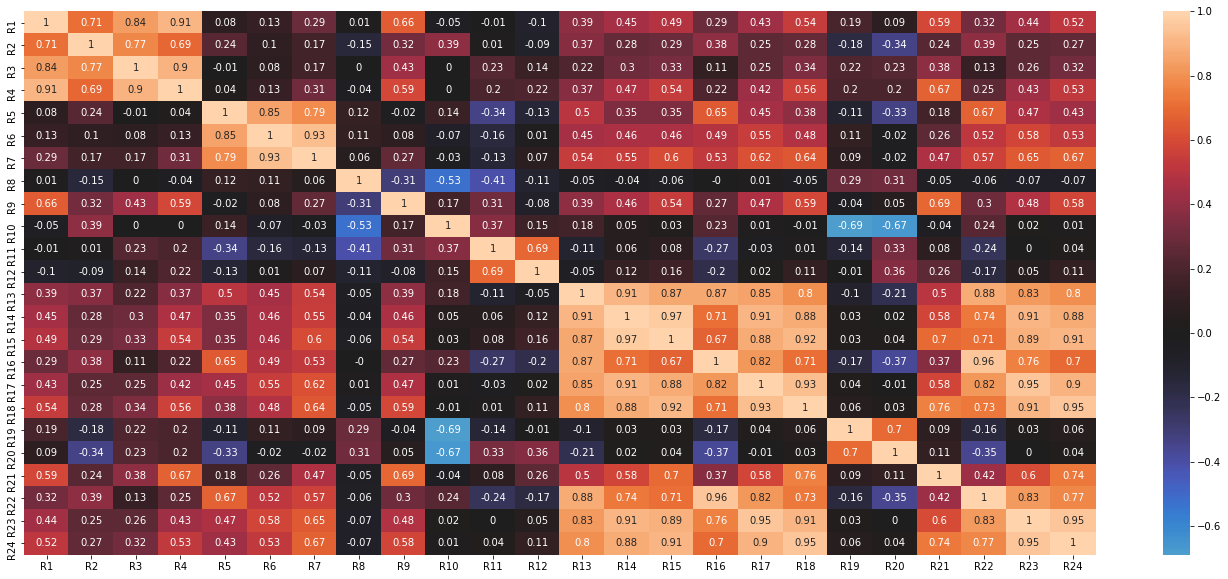

In [13]:
corr=df[columns_total].corr()
fig,ax=plt.subplots(figsize=(24,10))
sns.heatmap(corr.round(2),
            center=0,
            annot=True)

Nhìn từ ma trận tương quan có thể chia ra 4 nhóm biến có tương quan nhiều với nhau (>0.6):
- Nhóm 1: Biến R1 -> R4: Các chỉ số liên quan đến tiền mặt. Bộ chỉ số tương quan khá lớn với nhau thể
hiện xu hướng chung của tất cả các chỉ số tiền mặt. Biến Cash/Current debt thể hiện khả năng thanh toán 
nhanh của doanh nghiệp, có ý nghĩa đo lường dấu hiệu về khả năng phá sản của doanh nghiệp.
- Nhóm 2: Biến R5, R6, R7: Các chỉ số liên quan đến dòng tiền
- Nhóm 3: Biến R11, R12: Các chỉ số thể hiện cơ cấu các loại nợ và cơ cấu tài sản
- Nhóm 4: Biến R13 -> R18, R22 -> R24: Các chỉ số thể hiện doanh thu/lợi nhuận và nguồn vốn lưu động của doanh nghiệp.

Các biến này nếu sử dụng hết trong mô hình sẽ gây ra đa cộng tuyến, có thể cân nhắc lấy từ mỗi nhóm 1-
2 biến có tương quan thấp nhất và có ý nghĩa kinh tế. 

### 3. Mô hình Logistic

#### 3.1 Phân tích đơn biến: các kiểm định đơn biến gồm: 
- p-value: kiểm định ý nghĩa thống kê của hệ số hồi quy đơn biến - Ngưỡng chấp nhận <0.05
- K-S: kiểm tra sự khác biệt phân phối tích lũy của doanh nghiệp tốt và doanh nghiệp phá sả - Ngưỡng chấp nhận: >= 15%

In [14]:
#kiểm tra p-value
df_pvalue=pd.DataFrame([])
for i in columns_total:
    p_value=pd.DataFrame([])
    mod = sm.Logit(df['D'],df[i])
    fii=mod.fit()
    p_value['var']=[i]
    p_value['p-value']=[fii.pvalues.values[0]]
    df_pvalue=pd.concat([df_pvalue,p_value])
df_pvalue[df_pvalue['p-value']>=0.05]

Optimization terminated successfully.
         Current function value: 0.639203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.668478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690022
  

,var,p-value
0,R2,0.137006
0,R5,0.082053
0,R8,0.702082
0,R10,0.365131
0,R11,0.980138
0,R12,0.883962
0,R19,0.521989
0,R20,0.420018


In [15]:
##kiểm định ks
df_ks=pd.DataFrame([],columns=['variant','ks_test'])
for i in columns_total:
    df_ks_new=pd.DataFrame([],columns=['variant','ks_test'])
    new_rows={'variant':i, 'ks_test': kstest(df[i],'norm')[0]}
    df_ks_new=df_ks_new.append(new_rows, ignore_index=True)
    df_ks=pd.concat([df_ks,df_ks_new],ignore_index=True)
df_ks[df_ks['ks_test']>0.15]

,variant,ks_test
0,R1,0.500403
1,R2,0.500000
2,R3,0.500000
3,R4,0.500000
4,R5,0.462157
5,R6,0.448778
6,R7,0.402829
7,R8,0.889922
8,R9,0.765587
9,R10,0.539828


Các biến loại sau khi phân tích đơn biến gồm: R2,R5,R8,R10,R11,R12,R19,R20)

####  Loại các biến tương quan: 
Với mỗi nhóm trong nhóm tương quan (4 nhớm như mục 2.5), chọn lấy 1 biến có tiêu chuản kỹ thuật (p-value,KS) tốt nhất:
- Loại R2,R3,R6,R13,R14,R15,R16,R17,R22,R23
- => Còn 6 biến thoải mãn đưa vào phân tích đa biến: R1,R7,R9,R18,R21,R24

#### 3.2. Phân tích đa biến: 
- Hệ số lạm phát phương sai (VIF): cho biết phương sai (sai số) của một hệ số hồi quy tăng lên bao 
nhiêu lần do tương quan với các biến còn lại trong mô hình. Ngưỡng chấp nhận được của tiêu chuẩn này 
là: VIF <10%

In [16]:
var=[]
for i in [1,7,8,18,21,24]:
    var_add=['R' + str(i)]
    var=var + var_add
df_vif=df[var]
vif_df_check=pd.DataFrame()
vif_df_check['variant']=df_vif.columns
vif_df_check ['VIF']= [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif_df_check

,variant,VIF
0,R1,3.944460
1,R7,2.675556
2,R8,2.921006
3,R18,17.431791
4,R21,7.118003
5,R24,16.529850


In [17]:
df_vif=df[var]
vif_df_check=pd.DataFrame()
vif_df_check['variant']=df_vif.columns
vif_df_check ['VIF']= [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif_df_check

,variant,VIF
0,R1,3.944460
1,R7,2.675556
2,R8,2.921006
3,R18,17.431791
4,R21,7.118003
5,R24,16.529850


In [18]:
#Loại R18
var=[]
for i in [1,7,8,21,24]:
    var_add=['R' + str(i)]
    var=var + var_add
df_vif=df[var]
vif_df_check=pd.DataFrame()
vif_df_check['variant']=df_vif.columns
vif_df_check ['VIF']= [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif_df_check

,variant,VIF
0,R1,3.894432
1,R7,2.674616
2,R8,2.919496
3,R21,6.935495
4,R24,3.895891


### => Các biến cuối cùng đưa vào mô hình: R1,R7,R8,R21,R24

#### 3.3.Xây dựng và đánh giá mô hình

In [19]:
#chia tập train/test
y = df['D'].values
x = df[var].values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1, stratify=y)
print(y_train.sum()/len(y_train), y_test.sum()/len(y_test))

0.5 0.5


In [20]:
#chua hoa dư lieu
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [21]:
#mô hình LG với gridsearchcv để tinh chỉnh tham số hệ số phạt
lr_select=LogisticRegression(random_state = 5)
lr_para_grid={'C':[0.001,0.01,0.05,0,0.1,1,10,20]}
lr_search=GridSearchCV(lr_select,param_grid=lr_para_grid,cv=10, scoring='roc_auc')
lr_search.fit(x_train, y_train)
logictics_model = LogisticRegression(random_state = 5,C=lr_search.best_params_['C'])
# auroc_train = cross_val_score(logictics_model , x_train, y_train,scoring='roc_auc',cv = 10)
# print(auroc_train)
# print(auroc_train.mean())

In [22]:
#đánh giá mô hình; sử dụng chỉ số: auroc và confusion matrix
#auroc_train
auroc_train_kfold = cross_val_score(logictics_model , x_train, y_train,scoring='roc_auc',cv = 10)
lr_auroc_train=auroc_train_kfold.mean()
#auroc_test
logictics_model.fit(x_train, y_train)
lr_auroc_test = roc_auc_score(y_test, logictics_model.predict_proba(x_test)[:,1])
#confusion_matrix
lr_y_pre = logictics_model.predict(x_test)
lr_confusion_matrix = confusion_matrix(y_test, lr_y_pre)
#accuracy
lr_accuracy=accuracy_score(y_test, lr_y_pre)

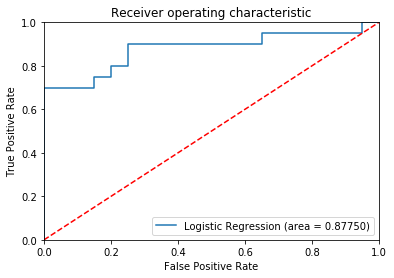

In [23]:
lr_auroc_test = roc_auc_score(y_test, logictics_model.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logictics_model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.5f)' % lr_auroc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 4. Mô hình Random Forest

- Sử dụng phương pháp tìm feature importance để xác định số biến thích hợp đưa vào mô hình

In [24]:
y = df['D'].values
x = df[columns_total].values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=5, stratify=y)

In [25]:
#đưa vào mô hình random_forest
random_forest_classifier=RandomForestClassifier(n_estimators=100,random_state=5)
random_forest_classifier.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

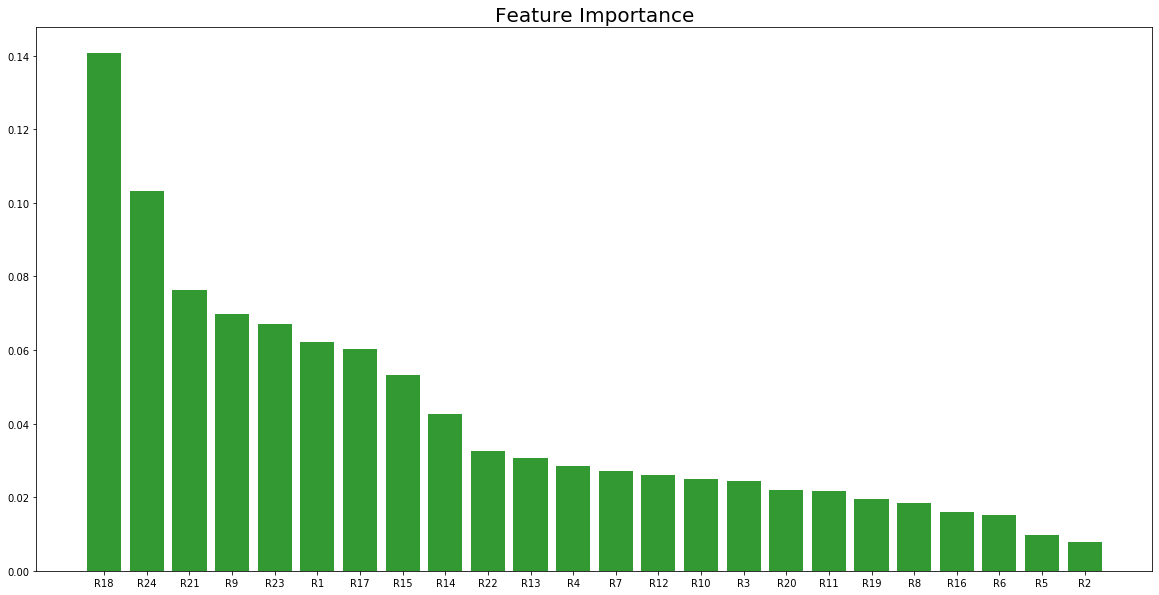

In [26]:
#feature importance
labels=df[columns_total].columns[0:]
importances=random_forest_classifier.feature_importances_
indices=np.argsort(importances)[:: -1]
plt.figure(figsize=(20,10))
plt.bar(range(x_train.shape[1]),importances[indices],color='g',align='center',alpha=0.8)
plt.xticks(range(x_train.shape[1]),labels[indices])
plt.title('Feature Importance',size=20)
plt.show()

In [27]:
#Lần lượt với từng biến đưa vào mô hình RF thì auroc traim/test là bnh => xác định số biến phù hợp trong mô hình cuối cùng 
importances=importances.sort()
df_rf_score=pd.DataFrame([])
random_forest_classifier=RandomForestClassifier(n_estimators=100,random_state=5)
random_forest_classifier.fit(x_train,y_train)
importances=random_forest_classifier.feature_importances_
for i in importances:
    df_rf_new=pd.DataFrame([])
    sfm=SelectFromModel(random_forest_classifier,threshold=i,prefit=True)
    x_train_important=sfm.transform(x_train)
    x_test_important=sfm.transform(x_test)
    random_forest=RandomForestClassifier(n_estimators=100,random_state=5)
    df_rf_new['auroc_train']=[cross_val_score(random_forest,x_train_important,y_train,scoring='roc_auc',cv = 10).mean()]
    random_forest.fit(x_train_important, y_train)
    #tinh test auc
    y_pre_important=random_forest.predict(x_test_important)
    fpr,tpr,thresholds=metrics.roc_curve(y_test,random_forest.predict_proba(x_test_important)[:,1])
    auc_test=metrics.auc(fpr,tpr)
    #add to new df
    df_rf_new['nbr_var']=[x_train_important.shape[1]]
    df_rf_new['threshod']=[i]
    df_rf_new['auroc_test']=[auc_test.round(3)]
    # add to final df
    df_rf_score=pd.concat([df_rf_score,df_rf_new])    

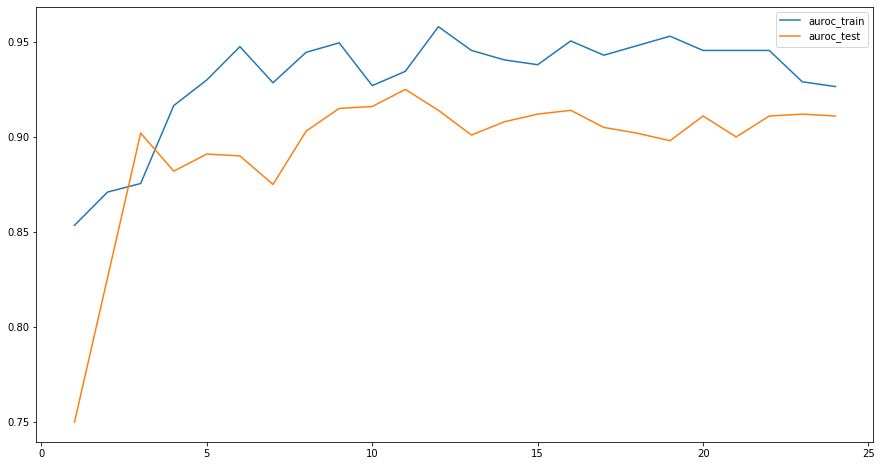

In [28]:
df_rf_score=df_rf_score.sort_values('nbr_var')
fig,ax=plt.subplots(figsize=(15,8))
ax.plot(df_rf_score['nbr_var'],df_rf_score['auroc_train'],label='auroc_train')
ax.plot(df_rf_score['nbr_var'],df_rf_score['auroc_test'],label='auroc_test')
plt.legend()

=> Từ đồ thị trên có thể thấy việc đưa 11 biến vào mô hình cho giá trị auroc ở tập test cao nhất cũng như giảm được overfiting của mô hình

In [39]:
##fine-tune hyperparameter với mô hình 11 biến 
rf_model=RandomForestClassifier(n_estimators=100,random_state=5)
rf_model.fit(x_train,y_train)
sfm=SelectFromModel(rf_model,threshold=0.029,prefit=True)
x_train_important=sfm.transform(x_train)
x_test_important=sfm.transform(x_test)
grid_search={'max_features':[2,3,4,5,6,7,8,9],
              'max_depth':[4,5,6,7,8],
            'min_samples_leaf':[2,3,4,5]
            }
rf_search=GridSearchCV (estimator=random_forest_classifier,param_grid=grid_search,cv=10,scoring='roc_auc')
rf_search.fit(x_train_important, y_train)
#auroc_test
y_pre_important=rf_search.predict(x_test_important)
fpr,tpr,thresholds=metrics.roc_curve(y_test,rf_search.predict_proba(x_test_important)[:,1])
rf_auroc_test=metrics.auc(fpr,tpr)
#auroc_train
rf_auroc_train=max(rf_search.cv_results_['mean_test_score'].round(3))
#confusion matrix, accuracy
rf_confusion_matrix = confusion_matrix(y_test, y_pre_important)
#accuracy
rf_accuracy=accuracy_score(y_test, y_pre_important)

### 5.Kết quả xây dựng mô hình

In [40]:
result=pd.DataFrame({
    'score': ['auroc_train','auroc_test','accuracy','confusion_matrix'],
    'Logistic Regression': [lr_auroc_train,lr_auroc_test,lr_accuracy,lr_confusion_matrix],
    'Random Forest Classifiaction' :[rf_auroc_train,rf_auroc_test,rf_accuracy,rf_confusion_matrix]
    },columns=['score','Logistic Regression','Random Forest Classifiaction'])
result

,score,Logistic Regression,Random Forest Classifiaction
0,auroc_train,0.896,0.947
1,auroc_test,0.8775,0.9175
2,accuracy,0.775,0.8
3,confusion_matrix,"[[16, 4], [5, 15]]","[[14, 6], [2, 18]]"


- Như vậy Random Forest cho kết quả tốt hơn